# Step 1: Import Libraries and Modules

In [29]:
import sys
sys.path.append('../src')

import pandas as pd
from data_loader import DataLoader
from features import FeatureEngineer
from train import Trainer
from evaluate import plot_confusion_matrix

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Step 2: Load Raw Data

In [30]:
data_path = '../data/raw/WA_Fn-UseC_-Telco-Customer-Churn.csv'
loader = DataLoader(data_path)
df = loader.load_data()
df = loader.basic_cleaning(df)

print("Dataset loaded and cleaned")
print(df.shape)
print(df.head())

Dataset loaded and cleaned
(7043, 21)
   customerID  gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
0  7590-VHVEG  Female              0     Yes         No       1           No   
1  5575-GNVDE    Male              0      No         No      34          Yes   
2  3668-QPYBK    Male              0      No         No       2          Yes   
3  7795-CFOCW    Male              0      No         No      45           No   
4  9237-HQITU  Female              0      No         No       2          Yes   

      MultipleLines InternetService OnlineSecurity  ... DeviceProtection  \
0  No phone service             DSL             No  ...               No   
1                No             DSL            Yes  ...              Yes   
2                No             DSL            Yes  ...               No   
3  No phone service             DSL            Yes  ...              Yes   
4                No     Fiber optic             No  ...               No   

  TechSupport StreamingT

# Step 3: Feature Engineering

In [31]:
target_col = 'gender'

# Identify categorical and numeric features
categorical_cols = df.select_dtypes(include='object').columns.tolist()
if target_col in categorical_cols:
    categorical_cols.remove(target_col)

numeric_cols = df.select_dtypes(include='number').columns.tolist()

from sklearn.preprocessing import LabelEncoder

le_target = LabelEncoder()
df[target_col] = le_target.fit_transform(df[target_col])  # Yes -> 1, No -> 0

#numeric_cols.remove('Churn')  # Assuming 'Churn' is target

fe = FeatureEngineer()
df = fe.encode_categoricals(df, categorical_cols)
df = fe.scale_features(df, numeric_cols)

print("Feature engineering completed")
print(df.head())

Feature engineering completed
   customerID  gender  SeniorCitizen  Partner  Dependents    tenure  \
0        5375       0      -0.439916        1           0 -1.277445   
1        3962       1      -0.439916        0           0  0.066327   
2        2564       1      -0.439916        0           0 -1.236724   
3        5535       1      -0.439916        0           0  0.514251   
4        6511       0      -0.439916        0           0 -1.236724   

   PhoneService  MultipleLines  InternetService  OnlineSecurity  ...  \
0             0              1                0               0  ...   
1             1              0                0               2  ...   
2             1              0                0               2  ...   
3             0              1                0               2  ...   
4             1              0                1               0  ...   

   DeviceProtection  TechSupport  StreamingTV  StreamingMovies  Contract  \
0                 0            0  

C:\Users\itman\AppData\Local\Temp\ipykernel_15220\3870569202.py:4: Pandas4Warning: For backward compatibility, 'str' dtypes are included by select_dtypes when 'object' dtype is specified. This behavior is deprecated and will be removed in a future version. Explicitly pass 'str' to `include` to select them, or to `exclude` to remove them and silence this warning.
See https://pandas.pydata.org/docs/user_guide/migration-3-strings.html#string-migration-select-dtypes for details on how to write code that works with pandas 2 and 3.
  categorical_cols = df.select_dtypes(include='object').columns.tolist()


# Step 4: Train Multiple Models


In [32]:
target_col = 'gender'  # Assuming this is the target
trainer = Trainer(df, target_col)
results = trainer.train_models()

print("\nModel Training Results:")
for model_name, metrics in results.items():
    print(f"{model_name}: Accuracy={metrics['accuracy']:.4f}, F1={metrics['f1_score']:.4f}, ROC-AUC={metrics['roc_auc']:.4f}")

c:\Users\itman\AppData\Local\Python\pythoncore-3.14-64\Lib\site-packages\sklearn\linear_model\_logistic.py:406: ConvergenceWarning: lbfgs failed to converge after 500 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=500).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



Model Training Results:
logistic_regression: Accuracy=0.4776, F1=0.5523, ROC-AUC=0.4876
random_forest: Accuracy=0.4961, F1=0.4877, ROC-AUC=0.4966


# Step 5: Evaluate Best Model (Random Forest)

In [33]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

X = df.drop(columns=[target_col])
y = df[target_col]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

best_model = RandomForestClassifier(n_estimators=100, random_state=42)
best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_test)

# Plot Confusion Matrix

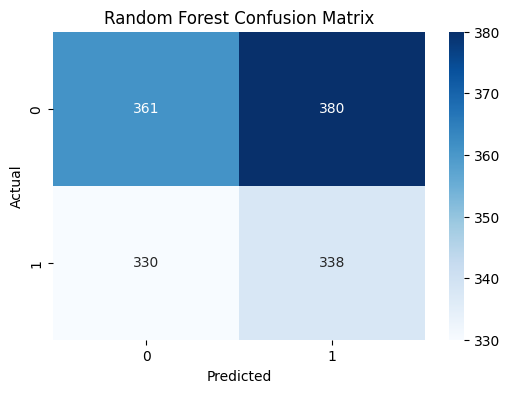

In [34]:
plot_confusion_matrix(y_test, y_pred, title="Random Forest Confusion Matrix")

# Plot Feature Importance

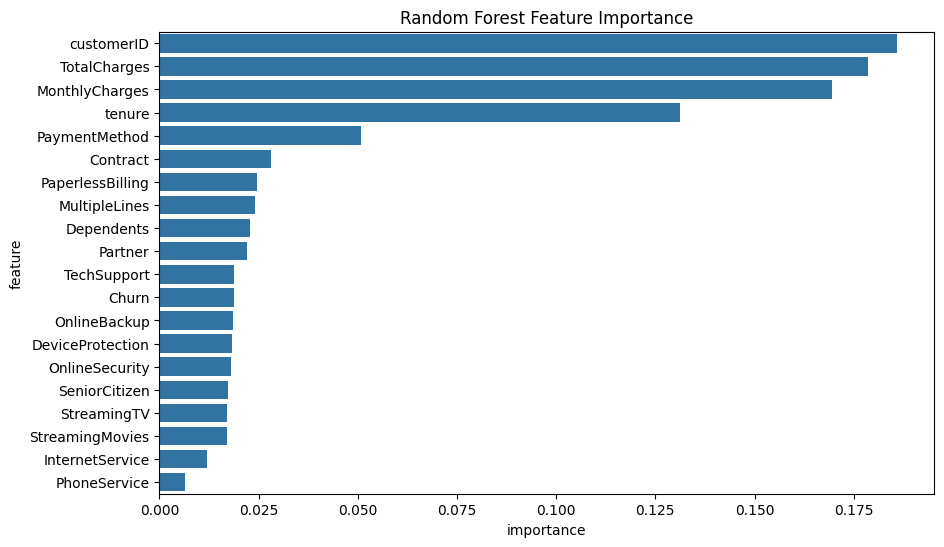

In [35]:
importances = best_model.feature_importances_
feature_names = X.columns
importance_df = pd.DataFrame({'feature': feature_names, 'importance': importances}).sort_values(by='importance', ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(x='importance', y='feature', data=importance_df)
plt.title("Random Forest Feature Importance")
plt.show()